# 3DeeCellTracker Demo: single mode

This notebook shows how to use 3DeeCellTracker to track cells in single mode.
The demo data can be found in the "single_mode_worm1" folder downloaded from https://osf.io/dt76c/

**The basic procedures:**
- A. Import packages
- B. Initialize the parameters for tracking
- C. Prepare images to be tracked, and the pre-trained U-Net and FFN models.
- D. Optimize segmentation parameters and segment the image at volume 1.
- E. Correct the segmentation at volume 1 (in other image processing software)
- F. Optimize tracking parameters.
- G. Track following volumes.


**Please run following codes according to the instructions**
- Some codes can be skipped if unnecessary.

## A. Import packages

In [1]:
%load_ext autoreload
%autoreload 2
import os
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
from matplotlib.animation import FuncAnimation, ArtistAnimation
from CellTracker.tracker import Tracker
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

2023-04-24 09:53:05.671411: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## B. Initialize the parameters for tracking
###  Set parameters for the tracker
**Image parameters**
- volume: number of the volumes (time points) of the images to be tracked
- siz_xyz: size of each 3D image: (height, width, depth), unit: voxels
- z_xy_ratio: resolution (um/voxels) ratio between z (depth) and x-y plane
- z_scaling: (integer), the factor for interpolating the unbalanced z_xy resolution

**Segmentation parameters**
- noise_level: a value close to the averaged non-cell region intensity, which helps the program to ignore the background noises.
- min_size: the possible minimal cell size, which helps the program to ignore small non-cell regions.
- Note: To change them after this initialization, please use ".set_segmentation()" which will delete the cached segmentation files

**Tracking parameters**
- beta_tk: set it higher/lower to get more coherent/independent predictions for cell positions.
- lambda_tk: set it higher/lower to get more coherent/independent predictions for cell positions.
- maxiter_tk: (integer) the number of iteration for the tracking algorithm (FFN+PR-GLS), the higher, the more accurate (but slower)

**Paths**
- folder_path: the path of the folder to store the data, model, and results.
    - "./xxx" indicates a folder with name "xxx" under the directory containing this jupyter notebook.
- image_name: the names of the images to be tracked. 
    - "aligned_t%03i_z%03i.tif" indicates file names like: "aligned_t002_z011.tif", "aligned_t502_z101.tif", etc.
- unet_model_file: the name of the pre-trained unet model file
- ffn_model_file: the name of the pre-trained ffn model file

### Notes: 
**Multiple folders were automatically created to store data, model, and results**
- /data: to store the images to be tracked
- /auto_vol1: to store the automatically generated segmentation results at volume 1
- /manual_vol1: to store the manually corrected segmentation results at volume 1
- /tracking_information: to store the coordinates information of the tracked cells
- /models: to store the pretrained and retrained models
- /unet: to store the cached predictions of cell regions
- /track_results_SingleMode: to store the tracking results (images of labels)
- /anim: to store the animation of the tracking process (used for diagnosis)
- /models/unet_weights: to store the retrained unet weights
- Note: in case one folder have been created, the program will not overwrite it.

In [2]:
tracker = Tracker(
    volume_num=50, siz_xyz=(512, 1024, 21), z_xy_ratio=9.2, z_scaling=10, 
    noise_level=20, min_size=100, beta_tk=300, lambda_tk=0.1, maxiter_tk=20, 
    folder_path=os.path.abspath("./worm1"), image_name="aligned_t%03i_z%03i.tif", 
    unet_model_file="unet3_pretrained.h5", ffn_model_file="ffn_pretrained.h5")

Following folders were made under: /home/wen/PycharmProjects/3DeeCellTracker/Examples/use_unet
worm1/data
worm1/auto_vol1
worm1/manual_vol1
worm1/track_information
worm1/models
worm1/unet_cache
worm1/track_results_SingleMode
worm1/anim
worm1/models/unet_weights


## C. Prepare images and pre-trained models
**Prepare images**
- Move images to the created "/data" folder. The names of the images should be consistent with the parameter "image_name"
- Move the pre-trained 3D U-Net and FFN model files to the created "/models" folder

## D. Optimize segmentation parameters and segment the image at volume 1.

**D1. Modify the segmentation parameters (optional)**
- Please modify these segmentation parameters only when the following segmentation results are unsatisfied
- Note: the cached segmentation in "/unet" folder will be deleted after this modification

In [3]:
tracker.set_segmentation(noise_level=20, min_size=100)

Segmentation parameters were not modified


**D2. Segment cells at volume 1**

In [4]:
tracker.load_unet()
tracker.segment_vol1()

2023-04-24 09:53:10.033371: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-24 09:53:10.095539: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 09:53:10.095938: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3080 Ti computeCapability: 8.6
coreClock: 1.665GHz coreCount: 80 deviceMemorySize: 11.76GiB deviceMemoryBandwidth: 849.46GiB/s
2023-04-24 09:53:10.095951: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-24 09:53:10.097236: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-24 09:53:10.097262: I tensorflow/stream_executor

Loaded the 3D U-Net model
Load images with shape: (512, 1024, 21)
Segmented volume 1 and saved it


**D3. Draw the results of segmentation (Max projection)**

Segmentation results (max projection):


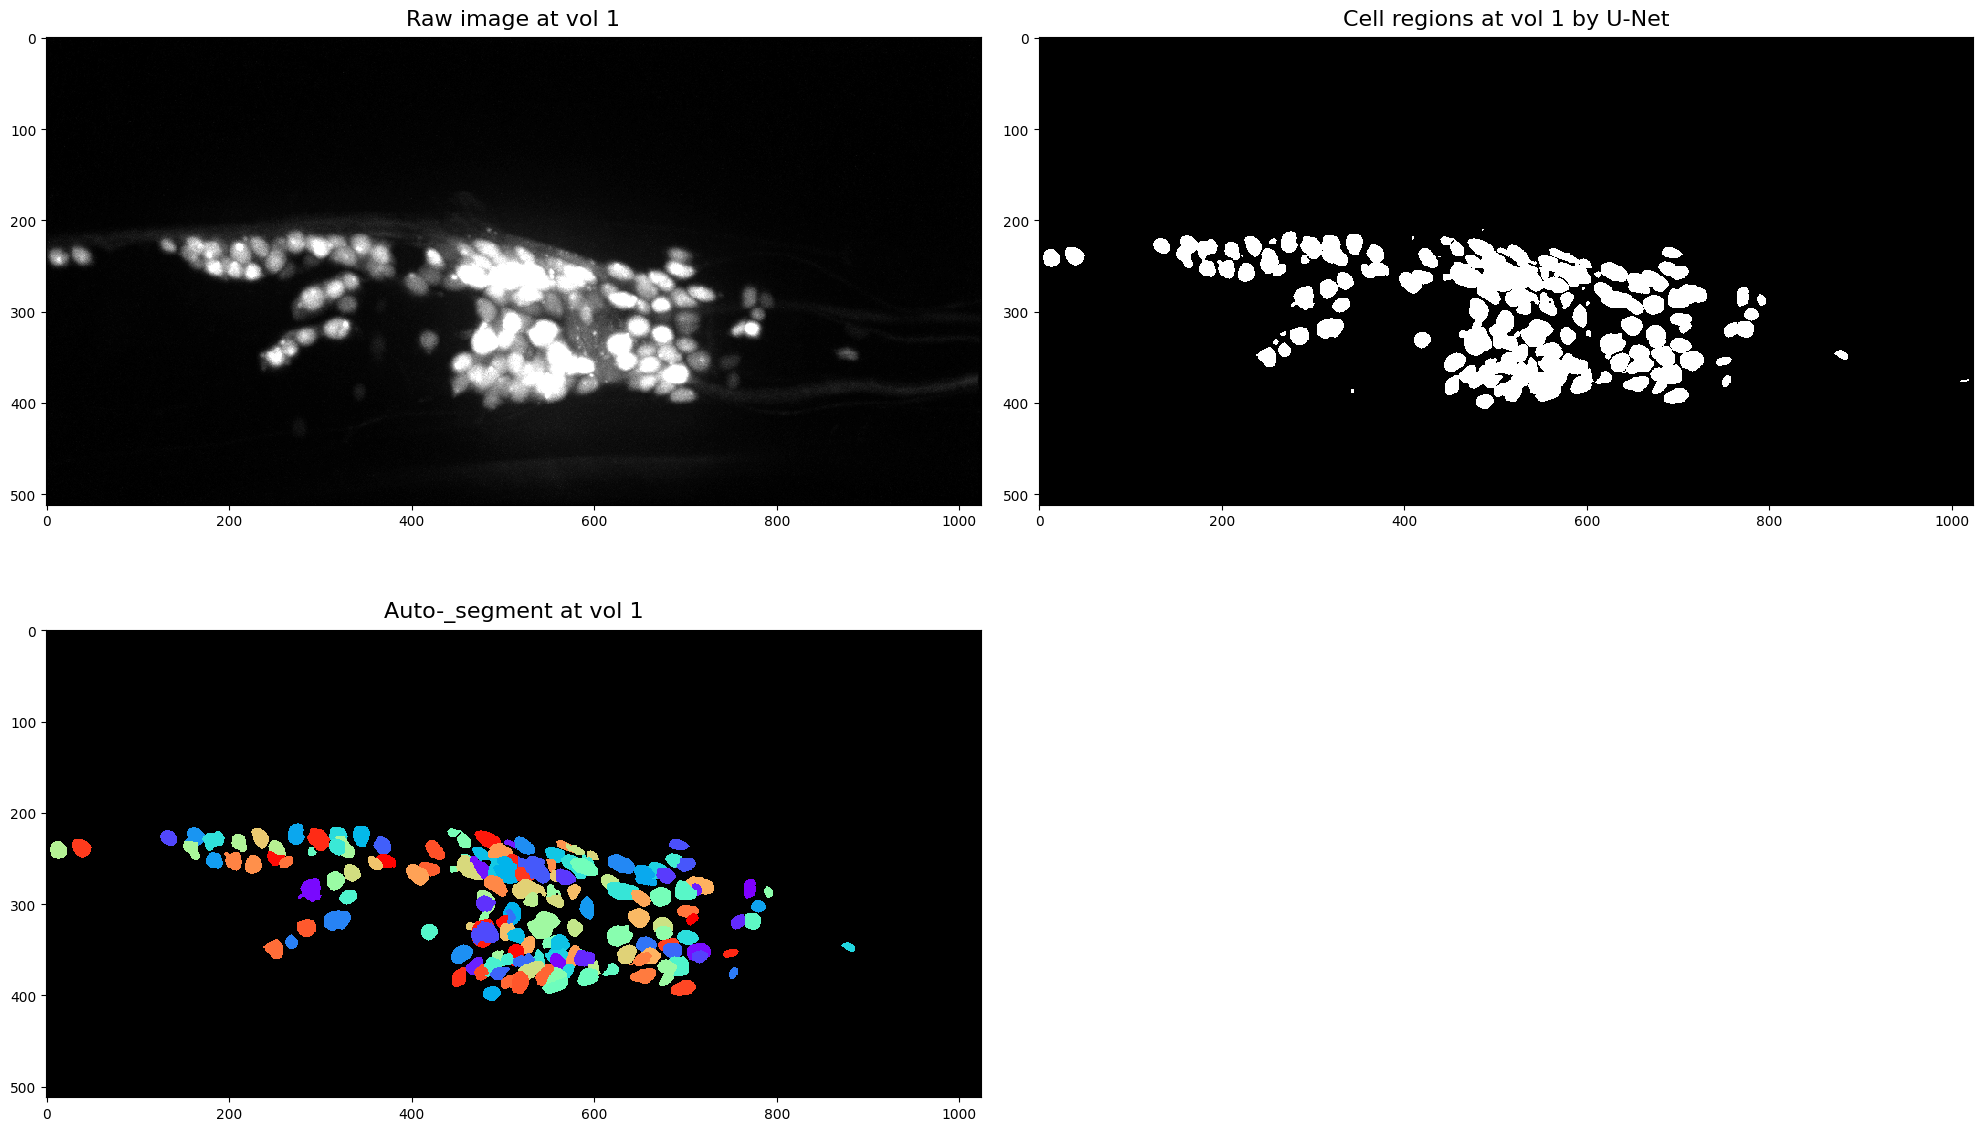

In [5]:
anim_seg = tracker.draw_segresult(percentile_high=99.8)

**D4. Show segmentation in each layer**

In [6]:
HTML(anim_seg)

## E. Manually correct the segmentation at volume 1 and load it.

**E1. Manual correction and move files to the folder**
- Delete non-cell regions;
- Add cells not labeled; 
- correct cell boundaries in other software (such as ITK-SNAP)

- save the corrected segmentation as 2D images (with different z)
- Move the corrected segmentation to the created "/manual_vol1" folder

**E2. Load the manually corrected segmentation**

In [7]:
tracker.load_manual_seg()

Loaded manual _segment at vol 1


**E3. Re-train the U-Net using the manual segmentation (optional)**
- Please do this only if the prediction by U-Net is poor (e.g. many cells were not ignored or many non-cell regions were identified as cells).

In [ ]:
tracker.retrain_unet()

- Set "step" with the satisfied segmentation result
- If the initial segmentation is better, set "step=0"

Segmentation parameters were not modified
All files under /unet folder were deleted
Load images with shape: (512, 1024, 21)


2023-04-23 16:12:27.909924: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-23 16:12:28.284606: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


Segmented volume 1 and saved it
Segmentation results (max projection):


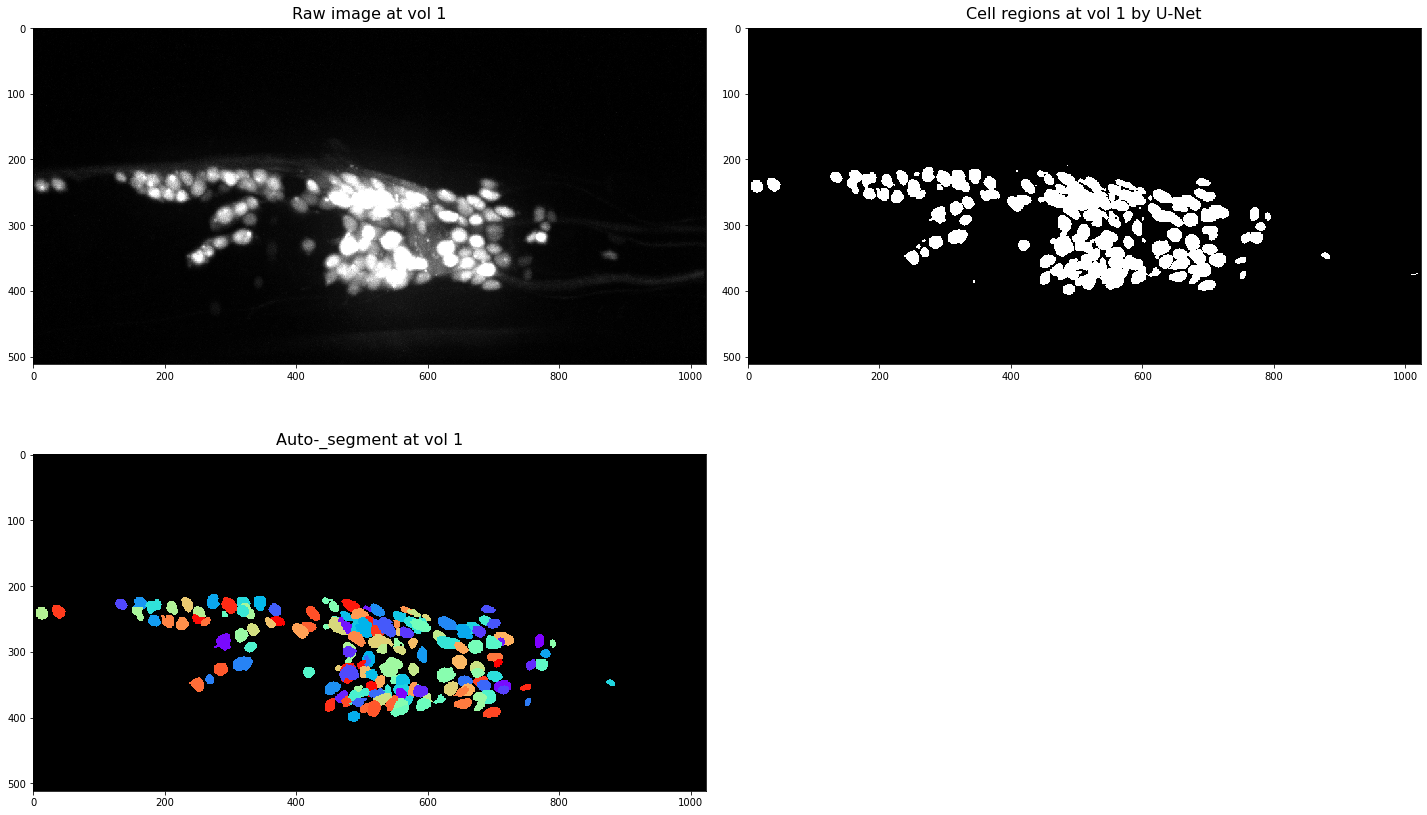

In [8]:
tracker.select_unet_weights(step=0)
tracker.set_segmentation(del_cache=True)
tracker.segment_vol1()
anim_seg = tracker.draw_segresult(percentile_high=99.8)

**E4. Interpolate cells to make more accurate/smooth cell boundary**

In [ ]:
tracker.interpolate_seg()
tracker.draw_manual_seg1()

**E5. Initiate variables required for tracking**
- cal_subregions(): required by "accurate correction" in following procedures
- check_multicells(): if multiple separated cells were labeled as the same one, generate an error message.

In [10]:
tracker.cal_subregions()
tracker.load_ffn()
tracker.initiate_tracking()

Calculating subregions... cell: 164
Loaded the FFN model
Initiated coordinates for tracking (from vol 1)


## F. Optimize tracking parameters. 
**F1. Modify tracking parameters if the test result is not satisfied (optional)**

In [11]:
tracker.set_tracking(beta_tk=300, lambda_tk=0.1, maxiter_tk=20)

Tracking parameters were not modified


**F2. Test a matching between volume 1 and a target volume, and show the FFN + PR-GLS process by an animation (5 iterations)**
- Red circles: manually corrected cells in vol 1
- Blue cross: cells detected by 3D U-Net in target volume
- Blue arrows: predicted transformation (cell movements)

In [ ]:
anim_tracking, results = tracker.match(target_volume=50)
HTML(anim_tracking)

**F3. Show the accurate correction after the FFN + PR-GLS transformation**
- Arrows show the correction of the cell positions
- Cells without arrow: no correction.

In [ ]:
tracker.draw_correction(*results[2:])

**F4. Show the superimposed cells + labels before/after tracking**

In [ ]:
tracker.draw_overlapping(*results[:3])

## G. Tracking following volumes
**G1. Track and show the processes**

In [ ]:
%matplotlib notebook
fig, ax = tracker.subplots_tracking()
tracker.track(fig, ax, from_volume=2)

**G2. Show the processes as an animation (for diagnosis)**

In [ ]:
%matplotlib inline
track_anim = tracker.replay_track_animation()
HTML(track_anim)